In [1]:
using WindTunnelFlow
using Plots

In [2]:
function suction_velocity!(vel,pts,t,phys_params)
    V_out = phys_params["V_out"]
    vel .= -V_out
end

function inflow_velocity!(vel,pts,t,phys_params)
    V_in = phys_params["V_in"]
    vel .= V_in
end

inflow_velocity! (generic function with 1 method)

In [3]:
# Wind tunnel characteristics

H_TS = 0.61 # m
W_TS = 0.61 # m
L_TS = 2.1 # m
u_0 = 2.0 # m/s
V_in_over_u_0 = 1.17 # He 2022, figure 9
V_TS_over_u_0 = 0.85 # He 2022, figure 9
x_SD_lo_over_L_TS = 0.4
x_SD_hi_over_L_TS = 0.6

0.6

In [4]:
V_in = V_in_over_u_0 * u_0
V_TS = V_TS_over_u_0 * u_0

A_TS = H_TS * W_TS # m^2
Q_TS = V_TS_over_u_0 * A_TS # m^3/s
Q_in = V_in_over_u_0 * A_TS # m^3/s
Q_SD = Q_in - Q_TS

x_SD_lo = x_SD_lo_over_L_TS * L_TS
x_SD_hi = x_SD_hi_over_L_TS * L_TS
L_SD = x_SD_hi - x_SD_lo
A_SD = L_SD * W_TS
V_out = Q_SD / A_SD

0.4647619047619047

In [5]:
params = Dict()
params["Re"] = 200
params["grid Re"] = 2.0
params["wind tunnel length"] = L_TS
params["wind tunnel height"] = H_TS
params["wind tunnel center"] = (L_TS / 2, H_TS / 2)
params["freestream speed"] = V_in
params["freestream angle"] = 0.0
params["V_in"] = V_in
params["V_out"] = V_out
params["V_TS"] = V_TS
t_final = 5.0
xlim = (-0.1 * L_TS, 1.1 * L_TS)
ylim = (-0.1 * H_TS, 1.1 * H_TS)
g = setup_grid(xlim, ylim, params)

PhysicalGrid{2}((270, 77), (30, 8), 0.01, ((-0.29, 2.39), (-0.07, 0.68)))

In [6]:
# Create the inflow

N = ceil(Int, H_TS / surface_point_spacing(g,params))
inflow_boundary = BasicBody(
    zeros(N),
    collect(range(0, H_TS, N)),
    closuretype=RigidBodyTools.OpenBody)
inflow = UniformFlowThrough(inflow_boundary,inflow_velocity!,3)

params["inlets"] = [inflow]

1-element Vector{UniformFlowThrough}:
 UniformFlowThrough(Basic pointwise-specified body with 43 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0
, inflow_velocity!, 3, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.4752325581395349, 0.48941860465116277, 0.5036046511627907, 0.5177906976744187, 0.5319767441860466, 0.5461627906976744, 0.5603488372093023, 0.5745348837209302, 0.5887209302325581, 0.602906976744186], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [7]:
# Create the suction at the top of the wind tunnel

N = ceil(Int, L_SD / surface_point_spacing(g,params))
suction_boundary = BasicBody(
    collect(range(x_SD_lo, x_SD_hi, N)),
    H_TS * ones(N);
    closuretype=RigidBodyTools.OpenBody)
suction = UniformFlowThrough(suction_boundary,suction_velocity!,1)

params["outlets"] = [suction]

1-element Vector{UniformFlowThrough}:
 UniformFlowThrough(Basic pointwise-specified body with 29 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0
, suction_velocity!, 1, [0.8472413793103449, 0.8617241379310345, 0.8762068965517242, 0.8906896551724139, 0.9051724137931035, 0.9196551724137931, 0.9341379310344828, 0.9486206896551725, 0.9631034482758621, 0.9775862068965517  …  0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

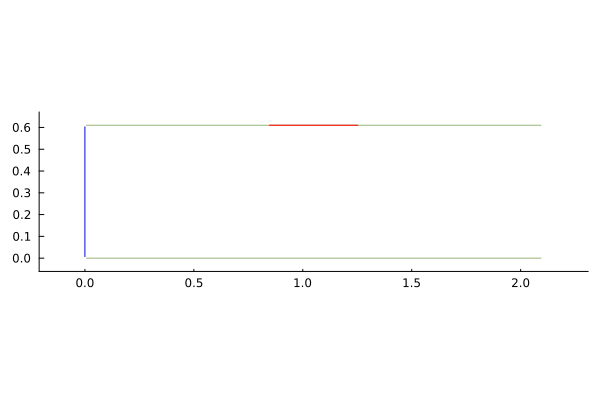

In [8]:
wt_walls = create_windtunnel_boundaries(g,params,withinlet=false)
plot(wt_walls,xlim=xlim,ylim=ylim)
plot!(suction.boundary,lc=:red)
plot!(inflow.boundary,lc=:blue)

In [ ]:
prob = WindTunnelProblem(g,phys_params=params;timestep_func=ViscousFlow.DEFAULT_TIMESTEP_FUNC,
                                   bc=ViscousFlow.get_bc_func(nothing))
sys = construct_system(prob);

In [ ]:
u0 = init_sol(sys)
tspan = (0.0,t_final)
integrator = init(u0,tspan,sys);

In [ ]:
step!(integrator)
sol = integrator.sol;

In [ ]:
ψ = zeros_gridcurl(sys)
ViscousFlow.streamfunction!(ψ,integrator.sol.u[end].x[1],sys,0.0)
plot(ψ,g,title="streamfunction",xlims=xlim,ylims=ylim)
plot!(wt_walls)

In [ ]:
wt_vel = zeros_grid(sys);
freestream_func = ViscousFlow.get_freestream_func(sys.forcing)
Vinf = freestream_func(0.0,params)
ViscousFlow.velocity!(wt_vel, zeros_gridcurl(sys), sys, 0.1);
vel_fcn = interpolatable_field(wt_vel,g);

In [ ]:
plot(wt_vel,size=[1100,200])

In [ ]:
x_centerline = -0.1*L_TS:0.01:1.1*L_TS
y_centerline = H_TS / 2 * ones(length(x_centerline))
u_centerline = vel_fcn[1].(x_centerline, y_centerline)
v_centerline = vel_fcn[2].(x_centerline, y_centerline)
aoa_centerline = 180 / π * atan.(v_centerline,u_centerline) # degrees

plot(x_centerline,u_centerline./ u_0, xlabel="x", label="u/u0")
plot!(x_centerline,v_centerline ./ u_0, label="v/u0")

In [ ]:
plot(x_centerline,aoa_centerline,xlim=[0,L_TS],xlabel="x",ylabel="aoa [degrees]",legend=false)